In [12]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


Read in the Data 

In [13]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()




,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.111200,0.041050,0.1388,0.06570,...,12.48,37.16,82.28,474.2,0.12980,0.25170,0.36300,0.09653,0.2112,0.08732
308,13.50,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,0.05335,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.039870,0.037000,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.13850,0.12660,0.12420,0.09391,0.2827,0.06771
377,13.46,28.21,85.89,562.1,0.07517,0.04726,0.012710,0.011170,0.1421,0.05763,...,14.69,35.63,97.11,680.6,0.11080,0.14570,0.07934,0.05781,0.2694,0.07061
183,11.41,14.92,73.53,402.0,0.09059,0.08155,0.061810,0.023610,0.1167,0.06217,...,12.37,17.70,79.12,467.2,0.11210,0.16100,0.16480,0.06296,0.1811,0.07427


In [14]:
# check for null values 
data.isnull().sum().sum()

0

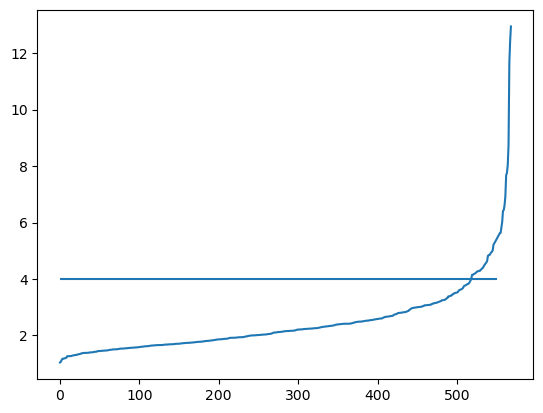

In [15]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=4, xmin=0, xmax=550)
# best eps around 3.75
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 31


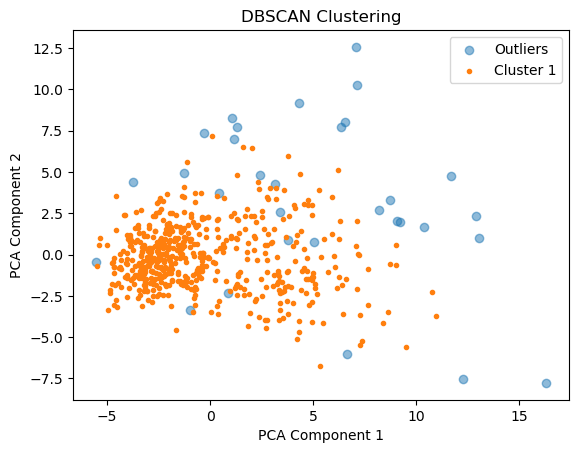

In [16]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

for label in np.unique(labels):
    if label == -1:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='o', label='Outliers', alpha=0.5)
    else:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='.', label=f'Cluster {label + 1}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


In [17]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [18]:
outputs = []


In [ ]:


#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,6,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Chosen max_depth: 37
Chosen min_samples_leaf: 1
Chosen max_depth: 37
Chosen min_samples_leaf: 1


In [ ]:
#ADA Boosting
param_grid = {
    'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



In [ ]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': list(range(10, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


In [ ]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': list(range(7,13)),
    'knn__n_neighbors': list(range(3,7))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



In [ ]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,),(70,),(80,)],
    "nn__activation": ["logistic","tanh","relu"],
    "nn__max_iter" : [200,250,300,350]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



In [ ]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

In [ ]:
## save model here?